# Modeling

Данный ноутбук посвящён вопросам моделинга

Как всегда импортируем библиотеки и прописываем пути к файлам

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from statistics import mean

from tqdm import tqdm
import copy

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier

import faiss
from faiss import write_index

import pickle

from typing import Dict, List, Tuple, Callable

In [2]:
PATH_TRAIN_FAISS = 'data/preprocessing/train_faiss.csv'
PATH_TEST_FAISS = 'data/preprocessing/test_faiss.csv'
PATH_VALID_FAISS = 'data/preprocessing/valid_faiss.csv'

PATH_TFIDFVECTORIZER = 'models/tfidf.pkl'

PATH_TRAIN_CORPUS = 'data/preprocessing/train_corpus.npz'
PATH_TEST_CORPUS = 'data/preprocessing/test_corpus.npz'
PATH_VALID_CORPUS = 'data/preprocessing/valid_corpus.npz'

RANDOM_STATE = 54321

Загрузим датасеты для обучения

In [3]:
df_train = pd.read_csv(PATH_TRAIN_FAISS)
df_test = pd.read_csv(PATH_TEST_FAISS)
df_valid = pd.read_csv(PATH_VALID_FAISS)

Для того открыть векторизованные корпуса создадим функцию, которая прочитает разряженные матрицы

In [4]:
def load_sparse_csr(filename: str):
    loader = np.load(filename)
    return scipy.sparse.csr_matrix((loader['data'],
                                    loader['indices'],
                                    loader['indptr']),
                                   shape=loader['shape'])

Загрузим векторизованные корпуса

In [5]:
corpus_train = load_sparse_csr(PATH_TRAIN_CORPUS)
corpus_test = load_sparse_csr(PATH_TEST_CORPUS)
corpus_valid = load_sparse_csr(PATH_VALID_CORPUS)

## Модель для нахождения k претендентов на кавер.

Для решения задачи группировки треков будем использовать faiss данная библиотека работает немного быстрее классического варианта K-ближайших, а также имеет возможность дальнейшей оптимизации. Чтобы оценивать качество работы данной модели, а также подбирать гиперпарамтеры воспользуемся метрикой **𝑅𝑒𝑐𝑎𝑙𝑙@𝑘** (полнота на k элементах), поскольку для данного этапа нам необходимо сделать модель, которая будет отбирать максимально подходящие треки для данного трека.

Её можно рассчитать по формуле:

$$ Recall@k =  {\sum найденных \space в \space топk \space матчей \over \sum матчей} $$

Созадим функцию для её рассчёта:

In [6]:
def score_recall_k(y_true: pd.Series, y_pred: pd.Series) -> float:
    metrick_list = []
    for i, y_p in enumerate(y_pred):
        # проверим есть ли для данного трека вообще каверы, tсли есть, то посчитаем количество вхождений
        if y_true[i] is not np.nan:
            for y_t in y_true[i].split():
                metrick_list.append(1 if y_t in y_p else 0)
    return mean(metrick_list)    

Создадим словарь с track_id тренировочного датасета, поскольку фаис будет возвращать индекс строки, а проверять нам потребуется track_id

In [7]:
id_base_dict = dict(df_train['track_id'])

Получим цели обучения (списки с track_id каверов)

In [8]:
y_train = df_train['cover_list']
y_test = df_test['cover_list']
y_valid = df_valid['cover_list']

Напишем функцию для тренировки faiss

In [9]:
def faiss_fit(corpus_train: scipy.sparse, 
              n_list: int = 1, 
              random_state: int = 54321) -> faiss.IndexIVFFlat:
    x_train = copy.deepcopy(corpus_train)
    d = x_train.shape[1] 
    nb = x_train.shape[0] 
    np.random.seed(random_state) 

    xb = x_train.toarray()

    nlist = n_list
    quantizer = faiss.IndexFlatIP(d)  
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)
    
    return index

Создадим функцию для предсказаний

In [10]:
def faiss_predict(index: faiss.IndexIVFFlat, 
                  corpus_test: scipy.sparse, 
                  id_base_dict: Dict, 
                  k: int = 10) -> pd.Series:
    x_test = copy.deepcopy(corpus_test)
    xq_x_test = x_test.toarray()
    
    D, I = index.search(xq_x_test, k)
    predicted_list = []
    distance_list = []
    
    # перебираем все ответы и проверяем, чтобы они не были равны 1 и не равнялись
    for i, candidates in enumerate(I):
        cand_list = []
        dist_list = []
        for j, candidate in enumerate(candidates):
            if candidate != -1 and id_base_dict[candidate] != id_base_dict[i]:
                cand_list.append(id_base_dict[candidate])
                dist_list.append(D[i][j])
                
        predicted_list.append(cand_list)
        distance_list.append(dist_list)      

    return pd.Series(predicted_list), pd.Series(distance_list)

Обучим индекс.

In [11]:
f_index = faiss_fit(corpus_train, random_state=RANDOM_STATE)

Проверим качество модели на трейне

In [12]:
y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, 10)
score_recall_k(y_train, y_train_pred)

0.5926640926640927

Попробуем улучшить качество модели. Для начала поработаем с TfIdf будем экспериментировать н-граммами и максимальным количеством признаков.

### Подбор параметров TfidfVectorizer

In [13]:
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим функцию, которая на вход будет принимать датасет, стоп слова, и параметры для TfIdf, а возвращать датасет с информацией об изменение метрики в зависимости от этих параметров

In [14]:
def feature_selection_tf_idf(df: pd.DataFrame, 
                             id_base_dict,
                             y_train: pd.Series,
                             stopwords: nltk_stopwords.words,
                             min_ngram: int = 1,
                             max_ngram: int = 6,
                             min_features: int = 500,
                             max_features: int = 15500,
                             count_steps_features: int = 20,
                             random_state: int = 54321):
    score_df = pd.DataFrame(columns = ['n_gram', 'max_features', 'metric'])
    new_df = df.copy(deep=True)
    new_df['lemm_text'] = new_df['lemm_text'].fillna('')
    # определяем размер шага для признаков
    step_features = (max_features - min_features) // 20
    step_features = step_features if (max_features - min_features) % 20 == 0 else step_features + 1
    
    for n_gram in tqdm(range(min_ngram, max_ngram)):
        for count_features in range (min_features, max_features, step_features):
            tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, n_gram), max_features = count_features)
            corpus_train = tf_idf.fit_transform(new_df['lemm_text'])
            
            f_index = faiss_fit(corpus_train, random_state = random_state)
            y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, 10)
            metric = score_recall_k(y_train, y_train_pred)
            
            score_df.loc[len(score_df.index )] = [n_gram, count_features, metric]
            
    return score_df

In [15]:
df_score = feature_selection_tf_idf(df_train, id_base_dict, y_train, stopwords)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:43<00:00, 68.67s/it]


Посмотрим на получившийся датасет

In [16]:
df_score.head()

,n_gram,max_features,metric
0,1.0,500.0,0.603604
1,1.0,1250.0,0.592664
2,1.0,2000.0,0.585586
3,1.0,2750.0,0.585586
4,1.0,3500.0,0.590734


Создадим функцию, которая будет строить график по этому датасету

In [17]:
def draw_plot(df: pd.DataFrame):
    plt.figure(figsize = (10, 6))
    plt.title('Зависимость качества модели faiss от параметра max_features и количества n-gram векторизатора TfidfVectorizer')
    for n_gram in df['n_gram'].unique():
        df_for_plot = df[df['n_gram'] == n_gram]
        plt.plot(df_for_plot['max_features'], df_for_plot['metric'], label = f'n_gram {n_gram}')
    plt.xlabel('max_features')
    plt.ylabel('Recall@10')
    plt.legend()
    plt.grid()
    plt.show()

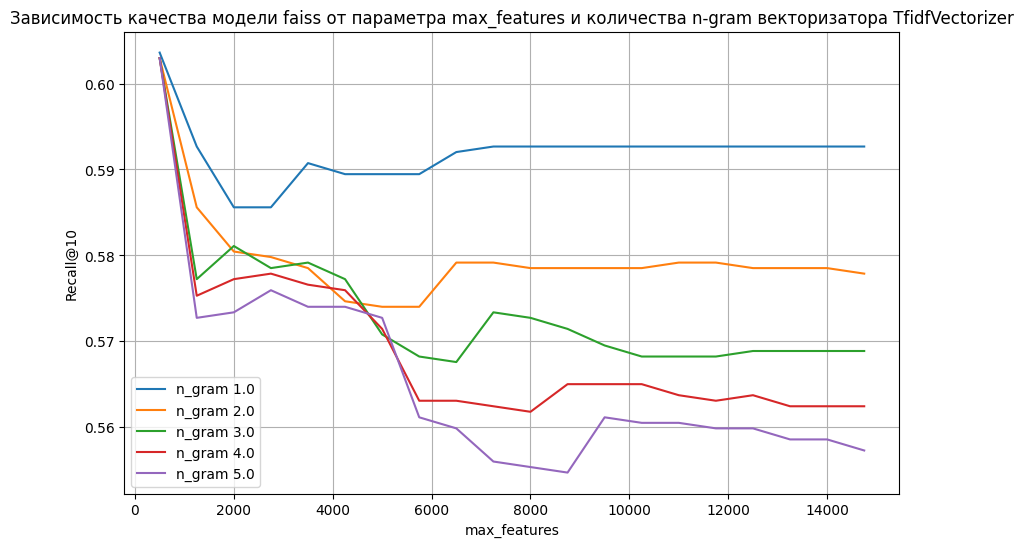

In [18]:
draw_plot(df_score)

Лучшие метрики получаются в районе max_features = 500 рассмотрим диапазон от 20 до 2000 более подробно

In [19]:
df_score = feature_selection_tf_idf(df_train, 
                                    id_base_dict,
                                    y_train, 
                                    stopwords, 
                                    min_features = 20, 
                                    max_features = 2000,
                                    count_steps_features=1000)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.74s/it]


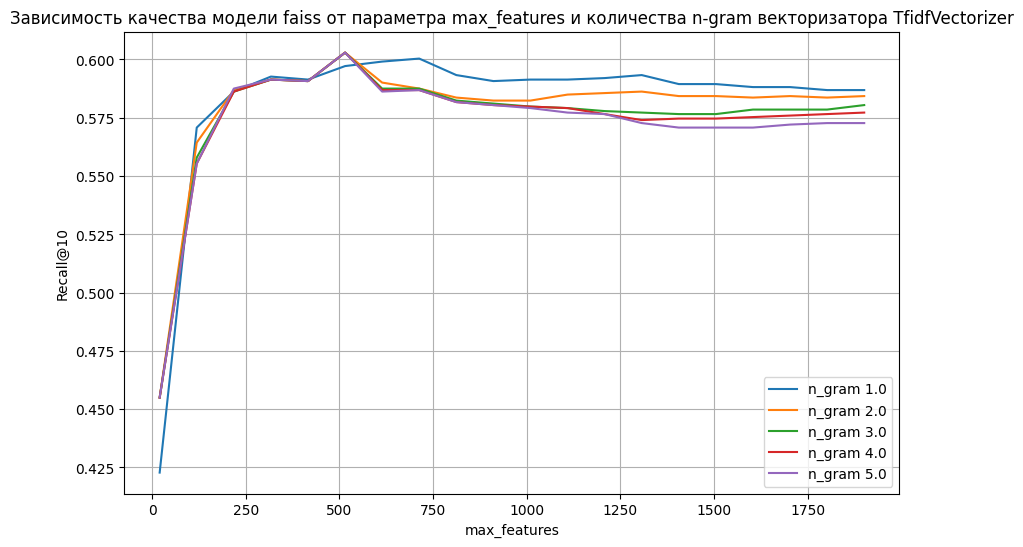

In [20]:
draw_plot(df_score)

На данном участке почти везде лидирует n_gram = (1,1), однаков районе 500 - 750 нельзя однозначно сказать, какие параметры лучше. Поэтому  расмотрим диапазон max_features от 220 до 760

In [21]:
df_score = feature_selection_tf_idf(df_train, 
                                    id_base_dict,
                                    y_train, 
                                    stopwords, 
                                    min_features = 220, 
                                    max_features = 760,
                                    count_steps_features=10)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:01<00:00, 24.30s/it]


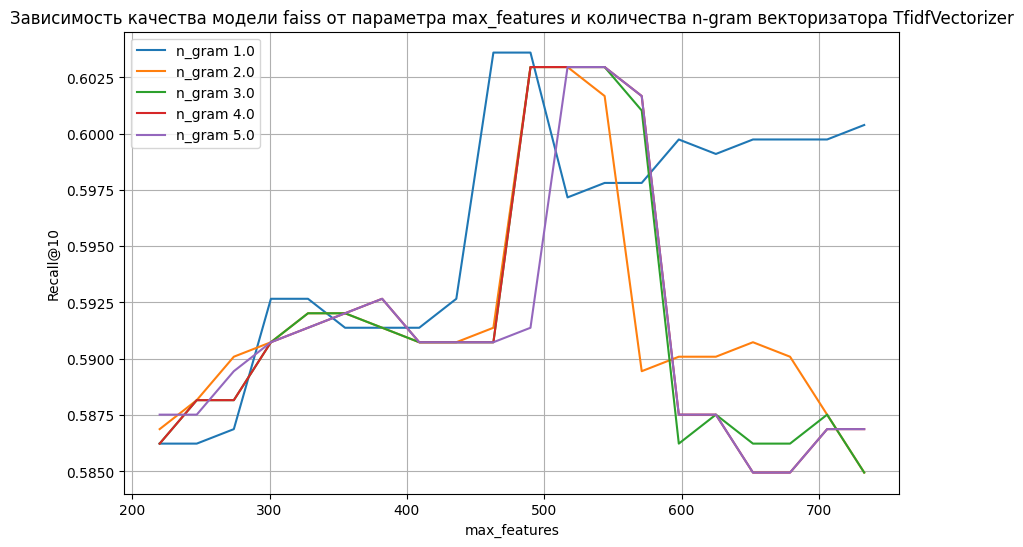

In [22]:
draw_plot(df_score)

На основании графиков можно сделать вывод, что лучше всего справляются n_gram = (1, 1) c max_features = 490

Переучим TfIdf и сформируем новые корпуса для дальнейшего исследования.

In [23]:
tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1), max_features = 490)
corpus_train = tf_idf.fit_transform(df_train['lemm_text'].fillna(''))
corpus_test = tf_idf.transform(df_test['lemm_text'].fillna(''))
corpus_valid = tf_idf.transform(df_valid['lemm_text'].fillna(''))

Пересохраним обученный TfIdf

In [24]:
pickle.dump(tf_idf, open(PATH_TFIDFVECTORIZER, "wb"))

### Подбор гиперпараметров для faiss

У самого faiss есть достаточно много гиперпарамеров, но в основном они направлены на оптимизацию скорости выполнения запроса, поэтому мы будем рассматривать изменение только одного параметра, а именно возвращаемое количество соседей (k). Ожидается, что при увеличении k постепенно будет увеличиваться Recall@k, но при этом точность модели будет падать, что усложнит дальнейшее обучение модели следующего этапа. Поэтому создадим функцию, которая будет рассччитывать точность на k образцах, а f1 меру посчитаем на основании полученных данных.

In [25]:
def score_precision_k(y_true: pd.Series, y_pred: pd.Series) -> float:
    metrick_list = []
    for i, y_t in enumerate(y_true):
        for y_p in y_pred[i]:       
            if y_t is np.nan:
                metrick_list.append(0)
            else:
                metrick_list.append(1 if y_p in y_t else 0)
    return mean(metrick_list)  

Напишем функцию, которая также будет возвращать датасет с метриками.

In [26]:
def feature_selection_tf_idf(corpus_train: scipy.sparse,
                             id_base_dict: Dict,
                             y_train: pd.Series,
                             min_k: int = 2,
                             max_k: int = 10,
                             random_state: int = 54321):
    score_df = pd.DataFrame(columns = ['k', 'recall', 'precision', 'f1'])
    
    for k in range(min_k, max_k):
        f_index = faiss_fit(corpus_train, random_state = random_state)
        y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, k=k)   
        rec = score_recall_k(y_train, y_train_pred)
        prec = score_precision_k(y_train, y_train_pred)
        f1 = 2 * rec * prec / (rec + prec)

        score_df.loc[len(score_df.index )] = [k, rec, prec, f1]
                
    return score_df

In [27]:
df_score = feature_selection_tf_idf(corpus_train,
                                    id_base_dict,
                                    y_train,
                                    max_k=40)

Построим график изменения качества модели

<Figure size 1000x900 with 0 Axes>

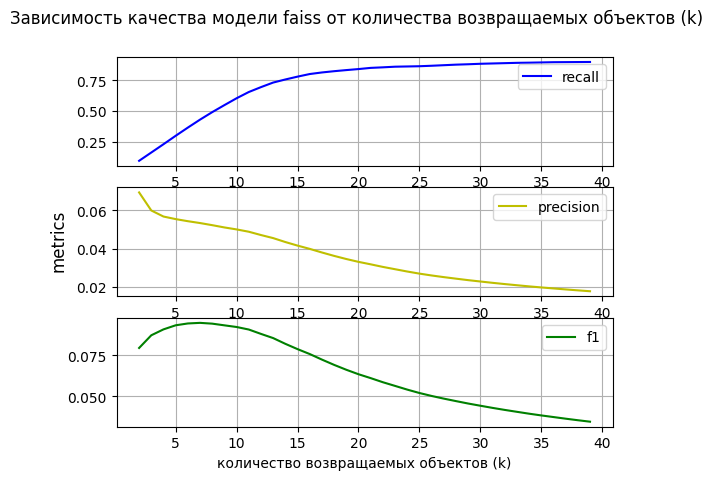

In [28]:
plt.figure(figsize = (10, 9))
fig, axs = plt.subplots(3)
fig.suptitle('Зависимость качества модели faiss от количества возвращаемых объектов (k)')
axs[0].plot(df_score['k'], df_score['recall'], label='recall', c='b')
axs[1].plot(df_score['k'], df_score['precision'], label='precision', c='y')
axs[2].plot(df_score['k'], df_score['f1'], label='f1', c='g')
plt.xlabel('количество возвращаемых объектов (k)')
fig.supylabel('metrics')
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

Как и ожидалось, при увеличении количества образцов полнота увеличилась, а точность начала падать. Однако, если анализировать данные f1, то оптимальное значение лежит в районе 7 - 8 образцов (будем брать 8). Именно его и будем использовать.

### Обучение индекса с выбранными параметрами на новом корпусе, проверка качества на тестовой выборке, изучение полученных результатов

Заново обучим индекс и посмотрим на показания recall 

In [29]:
f_index = faiss_fit(corpus_train, random_state=RANDOM_STATE)
y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, 8)
score_recall_k(y_train, y_train_pred)

0.49034749034749037

Проверим качество на тестовой выборке

Проверим качество модели на тесте

In [30]:
y_test_pred, dist_test_pred = faiss_predict(f_index, corpus_test, id_base_dict, 8)
score_recall_k(y_test, y_test_pred)

0.5574712643678161

На тестовой выборке получили примерно сопоставимое качество модели. 

Посмотрим как выглядят первы 5 строк нашего прогноза и какие значения расстояния выдаёт модель (изучать будет тренировочные данные).

In [31]:
y_train_pred[:5]

0    [17030debc293153f4209ea81928fcf33, b6840c6d29f...
1    [6c3b156b42de14fd1e222304d14ee50d, 17030debc29...
2    [dedfeed3c63e688509d138f80fd30b2f, 15ed971fdd0...
3    [ad368cb71bf8aa98e9629bf2a65fc446, 17030debc29...
4    [eb94e8aab853dcb0bb936b3b6a67ccd8, 9d3c03bb794...
dtype: object

In [32]:
dist_train_pred[:5]

0                  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
1    [0.040872756, 1.0000001, 1.0000001, 1.0000001,...
2    [0.5859686, 0.6376199, 0.8719157, 0.9094687, 0...
3                  [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
4    [0.5222106, 0.55571604, 0.56218755, 0.62411463...
dtype: object

Немного смущает 0 в 3 строчке, проверим эту строку в тренировочном датасете

In [33]:
df_train.loc[3:3]

,original_track_id,track_id,track_remake_type,translate_text,dttm,title,language,isrc,genres,duration,cover_list,lemm_text
3,43f4ccc81208af9ed8b646ddb3c89a31,43f4ccc81208af9ed8b646ddb3c89a31,ORIGINAL,"Every centimeter, every edge of the soul and b...",2021-03-26 17:17:51,Ты так красива,RU,RUA1D2111316,['POP'],173380.0,NaN,every centimeter every edge of the soul and bo...


Согласно разметке это оригинал и у него нет каверов. Выведем трек с 0 расстоянием из прогноза.

In [34]:
df_train[df_train['track_id']=='ad368cb71bf8aa98e9629bf2a65fc446']

,original_track_id,track_id,track_remake_type,translate_text,dttm,title,language,isrc,genres,duration,cover_list,lemm_text
1885,ad368cb71bf8aa98e9629bf2a65fc446,ad368cb71bf8aa98e9629bf2a65fc446,ORIGINAL,"Every centimeter, every edge of the soul and b...",2022-10-25 09:41:45,Ты так красива,RU,RUA1D2293955,"['POP', 'RUSPOP']",173380.0,NaN,every centimeter every edge of the soul and bo...


Как видим это одна и та же песня, но у них почему то разный track_id и isrc, Но обе почему-то имеют метку оригинала (возможно имеется проблема с разметкой датасета и это нужно будет проверить.

Проверим как много таких даных в датасете (посчитаем количество треков с 0 растоянием и разным original_track_id

In [35]:
count = 0
list_bad_track = []
for i in range(dist_train_pred.shape[0]):
    for j in range(len(dist_train_pred[i])):
        if dist_train_pred[i][j]==0:
            original_track_id_1 = df_train.loc[i, 'original_track_id']
            original_track_id_2 = (df_train
                                   .loc[df_train['track_id']==y_train_pred[i][j], 'original_track_id']
                                   .reset_index(drop=True)[0])
            if original_track_id_1 != original_track_id_2:
                count += 1
                list_bad_track.append((df_train.loc[i, 'track_id'],
                                       (df_train
                                       .loc[df_train['track_id']==y_train_pred[i][j], 'track_id']
                                       .reset_index(drop=True)[0])))
print(f'Количество пар треков с 0 расстоянием и разным original_track_id {count} ({count / y_train_pred.shape[0] * 100}%)')

Количество пар треков с 0 расстоянием и разным original_track_id 70 (3.358925143953935%)


У нас 70 таких пар. Убедимся в том, что алгоритм отработал корректно, выведем например десятую пару

In [36]:
df_train[df_train['track_id']==list_bad_track[10][0]]

,original_track_id,track_id,track_remake_type,translate_text,dttm,title,language,isrc,genres,duration,cover_list,lemm_text
431,dab794931ab35c33a9945be64e276500,dab794931ab35c33a9945be64e276500,ORIGINAL,"Cold bones\nYeah, that's my love\nShe glides a...",2022-01-20 21:00:00,Where's My Love,EN,CAN111700009,['INDIE'],202100.0,NaN,cold bone yeah that s my love she glide away l...


In [37]:
df_train[df_train['track_id']==list_bad_track[10][1]]

,original_track_id,track_id,track_remake_type,translate_text,dttm,title,language,isrc,genres,duration,cover_list,lemm_text
348,4500cc1d632ca30c29eb64fd4c41cef9,4500cc1d632ca30c29eb64fd4c41cef9,ORIGINAL,"Cold bones\nYeah, that's my love\nShe glides a...",2022-01-21 21:00:00,Where's My Love,EN,CAN111600624,['INDIE'],239880.0,NaN,cold bone yeah that s my love she glide away l...


Имеем схожую ситуацию, но при этом таких строк всего 70. Пока оставим эти данные как есть, а в дальнейшем, попробуем использовать их для улучшения качества модели.

### Выводы

В данном разделе была разработана и обучена модель для нахождения k ближайших треков, в качестве такой модели был выбран faiss. В ходе создания модели была проделана следующая работа:
1. Выбраны метрики качества и написаны функции для их определения;
2. Подобраны оптимальные параметры для TfIdf текстов песен (n_gram = (1, 1), max_features = 490);
3. Подобрано лучшее количество возвращаемых k ближайших (выбор осуществлялся на основании f1 меры, поскольку увеличение количества ближайших соседей увеличивает полноту, но просаживает точность)
4. В первом приближении исследованы результаты модели, было обнаружено, что в датасете отобранном для тренировочных данных 70 пар треков с 0 расстоянием и разным original_track_id (примерно 3.36%)

## Модель принимающая решения является ли пара треков каверами

После подбора наиболее подходящих треков создадим новый датасет и поверхнего обучим модель, которая будет решать является ли эта пара треков каверами / оригиналами. Для начала создадим датасет на основании предыдущего этапа моделирования. Рассмотрим следующие варианты создания датасета:

1. Добавления столбцов для обучения для каждого образца и добавления растояния между образцами;
2. Проверка на равнество для категориальных признаков, а для  количественных как в первом варианте;
3. Отношение для количественных признаков, а остальное как в первом варианте;
4. Объединение 2 и 3 варианта;
5. Объединение первых 3 вариантов (т.е. будем оставлять как первоначальные столбцы, так и сгенерированные).

Выделим нужные категориальные и числовые столбцы

In [38]:
cat_features = ['language', 'title']
num_features = ['duration']

### Проверка модели с сохранением всех прирзнаков для обоих образцов и добавлением расстояния между ними (модель 1)

Напишем функцию для переименования столбцов, так как нам потребуется разделять признаки для одного и для второго образца

In [39]:
def rename_columns(df: pd.DataFrame, ind: int) -> pd.DataFrame:
    df = df.copy(deep = True)
    ind = '_' + str(ind)
    columns_dict = dict()
    for column in df.columns:
        columns_dict[column] = column + ind
        
    df = df.rename(columns = columns_dict)
    return df

Создадим функцию для получения значения target, которое будет показывать входит ли трек с id_1 в состав каверов для трека с id_2 или наоборот.

In [40]:
def get_target(df: pd.DataFrame, id_1: str, id_2: str) -> int:
    target_value = ((~df.loc[df['track_id']==id_1, 'cover_list'].isna().any() and
                   id_2 in df.loc[df['track_id']==id_1, 'cover_list'].values[0]) or 
                   (~df.loc[df['track_id']==id_2, 'cover_list'].isna().any() and
                   id_1 in df.loc[df['track_id']==id_2, 'cover_list'].values[0]))
    return int(target_value)

Напишем  функцию для создания строки датасета по 2 заданным track_id

In [41]:
def get_row_to_df_v1(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    all_features = num_features + cat_features
    # получаем нудные столбцы
    df_1 = df.loc[df['track_id'] == id_1, all_features].reset_index(drop=True)
    df_2 = df.loc[df['track_id'] == id_2, all_features].reset_index(drop=True)
    # переименовываем столбцы
    df_1 = rename_columns(df_1, 1)
    df_2 = rename_columns(df_2, 2)
    # объединяем
    new_df = pd.concat([df_1, df_2], axis=1)
    # добавляем расстояние
    new_df['dist'] = dist
    if is_train:
        new_df['target'] = get_target(df, id_1, id_2)
    return new_df

Создадим функцию для генерации всего датсета, при этом сделаем так, что бы она на вход принимала функцию генерации признаков, это позволит в дальнейшем переиспользовать её.

In [42]:
def get_df(df: pd.DataFrame, 
           series_pred: pd.Series, 
           series_dist: pd.Series, 
           function: Callable, 
           cat_features: List[str] = [], 
           num_features: List[str] = [],
           is_train: bool = True) -> pd.DataFrame:
    new_df = pd.DataFrame()
    for i in tqdm(range(series_pred.shape[0])):
        list_pred = series_pred[i]
        list_dist = series_dist[i]
        for j in range(len(list_pred)):
            df_match = function(df, 
                                df.loc[i, 'track_id'], 
                                list_pred[j],
                                list_dist[j],
                                cat_features,
                                num_features)
            new_df = pd.concat([new_df, df_match])
    return new_df.reset_index(drop=True)

Сгенерируем датасет

In [43]:
df_cat_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v1, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2084/2084 [00:50<00:00, 41.66it/s]


In [44]:
df_cat_train.head()

,duration_1,language_1,title_1,duration_2,language_2,title_2,dist,target
0,188240.0,RU,Стань,155950.0,FR,Free to Feel,1.0,0
1,188240.0,RU,Стань,163290.0,EN,Over You,1.0,0
2,188240.0,RU,Стань,136640.0,EN,Fenomen,1.0,0
3,188240.0,RU,Стань,158690.0,RU,Du heru es,1.0,0
4,188240.0,RU,Стань,105880.0,EN,Enigma,1.0,0


Поскольку названия столбцов в датасете менялись, то нужно выбрать новые списки категориальных и числовых признаков

In [45]:
def get_features_list(df: pd.DataFrame,
                      cat_features: List[str] = [], 
                      num_features: List[str] = []) -> Tuple[List, List]:
    columns = df.columns
    new_cat_features = []
    new_num_features = []
    for column in columns:
        if column.split('_')[0] in cat_features:
            new_cat_features.append(column)
        if column.split('_')[0] in num_features:
            new_num_features.append(column)
    return new_cat_features, new_num_features

In [46]:
new_cat_features, new_num_features = get_features_list(df_cat_train, cat_features, num_features)

Посмотрим как распределён целевой признак.

In [47]:
df_cat_train['target'].mean()

0.05223471346312037

Выделим признаки и цели обучения

In [48]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

Как видим у нас всего около 5% матчей, поэтому при обучении необходимо указать модели на дисбаланс классов. Как отмечалось ранее для обучения будем использовать CatBoostClassifier. Поскольку у нас задача свелась к задачи классификации, то в качестве метрики будем использовать f1 меру.

In [49]:
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False)

Определять качество модели будем на кроссвалидации, поскольку у нас крайне мало целевых значений, то для разделения на фолды будем использовать StratifiedKFold

In [50]:
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

In [51]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.60049628 0.7124183  0.67820069 0.24770642]
Среднее значение f1 на всём датасете 0.5597054231572747
CPU times: total: 8min 57s
Wall time: 1min 15s


Проверим нашу гипотезу, что в данных сильный дисбаланс классов и передача весов, поможет улучшить качество модели.

In [52]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [53]:
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [54]:
%%time
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.66236559 0.70779221 0.68493151 0.27149321]
Среднее значение f1 на всём датасете 0.581645629677264
CPU times: total: 8min 25s
Wall time: 1min 11s


Действительно, сбалансированные веса позволяют улучшить качество модели.

### Проверка модели с сохранением числовых прирзнаков для обоих образцов и сравнением на равенство категориальных признаков (плюс сохранение дистанции)  (модель 2)

Создадим функцию, для реализации второй стратегии при которой проверяется равенство категориальных признаков

In [55]:
def get_row_to_df_v2(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # сравниваем категориальные столбцы
    new_df = pd.DataFrame()
    for column in cat_features:
        new_df[column] =pd.Series(df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  == df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0])
    # для числовых столбцов воспользуемся функцией написаной ранее
    num_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist,
                              num_features = num_features)    
    new_df = pd.concat([new_df ,num_df], axis=1)
    return new_df

Получим датасет

In [56]:
df_cat_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v2, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2084/2084 [01:20<00:00, 25.93it/s]


Выведем список первых 5 строк и убедимся, что всё отработало корректно (отношение 0 и 1 в таргете должно остаться прежним)

In [57]:
df_cat_train.head()

,language,title,duration_1,duration_2,dist,target
0,False,False,188240.0,155950.0,1.0,0
1,False,False,188240.0,163290.0,1.0,0
2,False,False,188240.0,136640.0,1.0,0
3,True,False,188240.0,158690.0,1.0,0
4,False,False,188240.0,105880.0,1.0,0


In [58]:
df_cat_train['target'].mean()

0.05223471346312037

Создадим и обучим модель (сразу будем обучать модель со сбалансированными весами)

In [59]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [60]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.750499   0.87262873 0.9182058  0.81767956]
Среднее значение f1 на всём датасете 0.8397532727609153
CPU times: total: 3min 8s
Wall time: 20.6 s


Качество модели стало значительно лучше, по сравнения с первым вариантом модели

### Проверка модели с сохранением категориальных прирзнаков для обоих образцов и получения отношения для числовых признаков (плюс сохранение дистанции) (модель 3)

Создадим функцию, для реализации третей стратегии при этом будем смотреть не просто отношение числовых признаков, а абсолютную разницу от единице (чем ближе будет значение к 0, тем меньше разница между числовыми признаками)

In [61]:
def get_row_to_df_v3(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # находим отношение для числовых признаков
    new_df = pd.DataFrame()
    for column in num_features:
        new_df[column] = pd.Series(abs(1 - df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  / df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0]))
    # для категориальных столбцов воспользуемся написанной ранее функцией
    cat_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist,
                              cat_features = cat_features)    
    new_df = pd.concat([new_df ,cat_df], axis=1)
    return new_df

Получим датасет

In [62]:
df_cat_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v3, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2084/2084 [01:08<00:00, 30.59it/s]


Выведем список первых 5 строк и убедимся, что отношение 0 и 1 в таргете должно остаться прежним

In [63]:
df_cat_train.head()

,duration,language_1,title_1,language_2,title_2,dist,target
0,0.207054,RU,Стань,FR,Free to Feel,1.0,0
1,0.152796,RU,Стань,EN,Over You,1.0,0
2,0.377635,RU,Стань,EN,Fenomen,1.0,0
3,0.186212,RU,Стань,RU,Du heru es,1.0,0
4,0.777862,RU,Стань,EN,Enigma,1.0,0


In [64]:
df_cat_train['target'].mean()

0.05223471346312037

Всё отработало корректно, обучим модель и посмотрим н аей качество

In [65]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [66]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.13483146 0.70779221 0.68493151 0.25454545]
Среднее значение f1 на всём датасете 0.4455251574652837
CPU times: total: 8min 45s
Wall time: 1min 12s


Качество модели оказалось хуже чем у других моделей.

### Проверка модели с получениум отношения для числовых признаков и сравнением на равенство категориальных признаков (плюс сохранение дистанции) (модель 4)

Создадим функцию, для реализации четвёртой стратегии: мы будем сравнивать как категориальные признаки, так и смотреть на соотношение числовх признаков

In [67]:
def get_row_to_df_v4(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # сравниваем категориальные столбцы
    cat_df = pd.DataFrame()
    for column in cat_features:
        cat_df[column] =pd.Series(df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  == df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0])  
        
    # находим отношение для числовых признаков
    num_df = pd.DataFrame()
    for column in num_features:
        num_df[column] = pd.Series(abs(1 - df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  / df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0]))
    # для получения таргета и дистанции воспользуемся функцией
    new_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist)    
    new_df = pd.concat([num_df ,cat_df, new_df], axis=1)
    return new_df

In [68]:
df_cat_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v4, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2084/2084 [01:29<00:00, 23.27it/s]


Проверим получившийся датасет

In [69]:
df_cat_train.head()

,duration,language,title,dist,target
0,0.207054,False,False,1.0,0
1,0.152796,False,False,1.0,0
2,0.377635,False,False,1.0,0
3,0.186212,True,False,1.0,0
4,0.777862,False,False,1.0,0


In [70]:
df_cat_train['target'].mean()

0.05223471346312037

Всё нормально, обучим модель и посмотрим на её качество

In [71]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [72]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.65543071 0.78772379 0.80272109 0.69041096]
Среднее значение f1 на всём датасете 0.7340716360290528
CPU times: total: 3min 12s
Wall time: 21.8 s


Качество модели лучше чем у 1 и 3 моделей, но хуже чем у второй.

### Проверка модели с получениум отношения для числовых признаков и сравнением на равенство категориальных признаков, а также использованием первоначальных признаков (плюс сохранение дистанции) (модель 5)

Создадим функцию, которая объединит в себе идеи 1, 2 и 3 модели

In [73]:
def get_row_to_df_v5(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # сравниваем категориальные столбцы
    cat_df = pd.DataFrame()
    for column in cat_features:
        cat_df[column] =pd.Series(df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  == df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0])  
        
    # находим отношение для числовых признаков
    num_df = pd.DataFrame()
    for column in num_features:
        num_df[column] = pd.Series(abs(1 - df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  / df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0]))
    # для получения таргета и дистанции воспользуемся функцией
    new_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist,
                              cat_features = cat_features,
                              num_features = num_features)    
    new_df = pd.concat([num_df ,cat_df, new_df], axis=1)
    return new_df

In [74]:
df_cat_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v5, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2084/2084 [01:41<00:00, 20.53it/s]


Как всегда проверим, что получилось на выходе

In [75]:
df_cat_train.head()

,duration,language,title,duration_1,language_1,title_1,duration_2,language_2,title_2,dist,target
0,0.207054,False,False,188240.0,RU,Стань,155950.0,FR,Free to Feel,1.0,0
1,0.152796,False,False,188240.0,RU,Стань,163290.0,EN,Over You,1.0,0
2,0.377635,False,False,188240.0,RU,Стань,136640.0,EN,Fenomen,1.0,0
3,0.186212,True,False,188240.0,RU,Стань,158690.0,RU,Du heru es,1.0,0
4,0.777862,False,False,188240.0,RU,Стань,105880.0,EN,Enigma,1.0,0


In [76]:
df_cat_train['target'].mean()

0.05223471346312037

Получим новые варианты категориальных и числовых столбцов

In [77]:
new_cat_features, new_num_features = get_features_list(df_cat_train, cat_features, num_features)

Обучим модель и проверим качество

In [78]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [79]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.72457627 0.70779221 0.68493151 0.24770642]
Среднее значение f1 на всём датасете 0.591251601961578
CPU times: total: 8min 55s
Wall time: 1min 14s


Модель оказалась немного лучше 1 модели, но уступает остальным в качестве.

### Выводы